In [1]:
import sinter
stats = sinter.stats_from_csv_files('./out/stats.csv')
print(stats)

[sinter.TaskStats(strong_id='a34b54c1ecd56f30326ab08cfb39ddcf8eadbaa38ae2d7948dcb891c87c94aec', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 4, 'gf_0': 1, 'gf_1': 1, 'gf_2': 1, 'per': 0.001, 'pm': 1.0, 'px': 1.0, 'py': 1.0, 'pz': 1.0}, shots=131, errors=11, seconds=0.453), sinter.TaskStats(strong_id='d213677303eb4f2c0e2173aec9987372163330f78400fe604cbedcf2c589af0f', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 4, 'gf_0': 1, 'gf_1': 1, 'gf_2': 2, 'per': 0.001, 'pm': 1.0, 'px': 1.0, 'py': 1.0, 'pz': 1.0}, shots=145, errors=13, seconds=0.479), sinter.TaskStats(strong_id='0d6baad19424ea4107048c5dc76c4c3c93452f84d55facdaac751c79e4dd3509', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 3, 'gf_2': 0, 'per': 0.001, 'pm': 1.0, 'px': 0.0, 'py': 0.0, 'pz': 0.0}, shots=1000, seconds=0.744), sinter.TaskStats(strong_id='5a1f54f0e03312d1e4a2c2e992ed8f5cc9cbeecd

In [2]:
from typing import Optional, List, Any, Tuple, Callable
import math
def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
) -> Optional[sinter.Fit]:
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:
                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['distance']**2))
                log_ps.append(math.log(p_unit))

    if len(log_ps) < 2:
        # Can't interpolate a slope from 1 data point.
        return None

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=math.log(target_p),
        max_extra_squared_error=1,
    )

    return sinter.Fit(
        low=fit.low**2,
        best=fit.best**2,
        high=fit.high**2,
    )


In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
markers = "ov*sp^<>8PhH+xXDd|" * 100
import matplotlib.colors
colors = list(matplotlib.colors.TABLEAU_COLORS) * 3


noise_model_groups = sinter.group_by(stats, key = lambda stat: str(stat.json_metadata['px'])+ ',' + str(stat.json_metadata['py']) + ',' + str(stat.json_metadata['pz']) + ',' + str(stat.json_metadata['pm']))

noise_model_footprints = defaultdict()

for noise_model_key, noise_model_group in noise_model_groups.items():
    code_name_groups = sinter.group_by(noise_model_group, key = lambda stat: stat.json_metadata['code_name'])
    noise_model_footprints[noise_model_key] = defaultdict()
    for code_name_key, code_name_group in code_name_groups.items():
        noise_model_footprints[noise_model_key][code_name_key] = extrapolate_footprint_achieving_error_rate(
                code_name_group,
                target_p=10**(-12),
                failure_unit_func=None)


print(noise_model_footprints)

defaultdict(None, {'1.0,1.0,1.0,1.0': defaultdict(None, {'GaugeHoneycombCode': None, 'GaugeFloquetColourCode': None}), '0.0,0.0,0.0,1.0': defaultdict(None, {'GaugeFloquetColourCode': None, 'GaugeHoneycombCode': None}), '1.0,1.0,1.0,4.0': defaultdict(None, {'GaugeHoneycombCode': None}), '1.0,1.0,1.0,8.0': defaultdict(None, {'GaugeHoneycombCode': None})})


In [181]:
def get_best_footprint(footprints):
    lowest_footprint = None
    lowest_footprint_name = None
    for code_name, footprint in footprints.items():

        if footprint is not None and (lowest_footprint is None or footprint.best < lowest_footprint):

            lowest_footprint = footprint.best
            lowest_footprint_name = code_name
    return lowest_footprint_name

best_footprints = dict()
for noise_model, footprints in noise_model_footprints.items():

    best_footprints[noise_model] = get_best_footprint(footprints)

code_name_to_color = {'FloquetColourCode': 1,'HoneycombCode': 10}
x_y_to_color = defaultdict()
x_values = list(  )
y_values = list()
for noise_model, best_footprint in best_footprints.items():
    x_y_to_color[(noise_model.split(',')[-2], noise_model.split(',')[-1])] = code_name_to_color[best_footprint]
    if noise_model.split(',')[-2] not in x_values:
        x_values.append(noise_model.split(',')[-2])
    if noise_model.split(',')[-1] not in y_values:
        y_values.append(noise_model.split(',')[-1])

x_values.sort()
y_values.sort()
y_values = y_values[::-1]
color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
for x_val in x_values:
    for y_val in y_values:
        if (x_val, y_val) in x_y_to_color:
            color_matrix[x_values.index(x_val)][y_values.index(y_val)] = x_y_to_color[(x_val, y_val)]


x_values = [float(x) for x in x_values]
y_values = [float(y) for y in y_values]

# go from px,py,pz,pm to x and y coordinate


# go from code_name to color


Text(0, 0.5, 'Measurement bias')

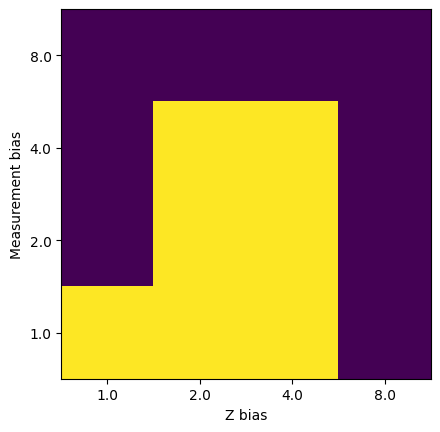

In [184]:
plt.imshow(color_matrix)
plt.xticks(np.arange(len(x_values)), labels=x_values)
plt.yticks(np.arange(len(y_values)), labels=y_values)
plt.xlabel('Z bias')
plt.ylabel('Measurement bias')

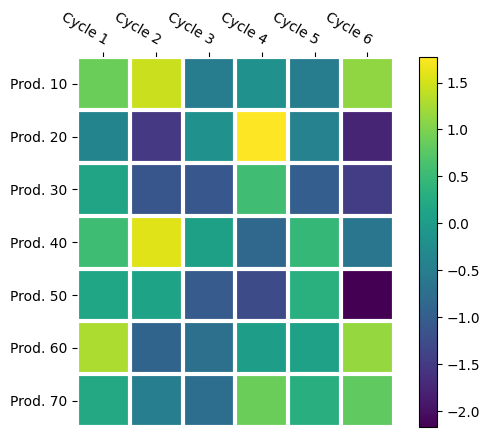

In [153]:
import numpy as np
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

data = np.random.randn(7, 6)
y = [f"Prod. {i}" for i in range(10, 80, 10)]
x = [f"Cycle {i}" for i in range(1, 7)]
qrates = list("ABCDEFG")
norm = matplotlib.colors.BoundaryNorm(np.linspace(-3.5, 3.5, 8), 7)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, _ = heatmap(data, y, x)



In [152]:
imshow
print(data)
print(colors)
#im, _ = heatmap(colors, y_cords, x_cords)


[[-0.07151069  1.18280717 -0.95828172  0.5717842   0.53571285  0.63972755]
 [-0.35030957  0.83208399 -1.3920888  -0.25202288  1.32337813 -0.27991457]
 [-0.99903546 -1.1257055   0.29360627 -0.11919822 -0.2198939   0.92073018]
 [-0.08638644  0.93319565  0.75481009 -1.45229548  1.12567024  0.6403062 ]
 [ 1.2766022  -0.81366911 -0.84092399 -0.29938742 -0.94413404  0.79590808]
 [-0.64452359 -0.38958075 -0.12229497 -0.19471646  0.21670726  0.72245511]]
[1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 10, 10, 1, 10, 10, 10]
